In [1]:
import xgboost as xgb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yaml
import datetime
import sys
from tqdm import tqdm
import os
import random
import pickle
from glob import glob
import gc
from multiprocessing import Pool, cpu_count

import warnings
warnings.filterwarnings('ignore')

sys.path.append('/kaggle')
from utils.xgb import fit_xgb, inference_xgb
from utils.metric import compute_comptetition_metric
from utils.feature_contena import Features
from utils.pandas_utils import reduce_mem_usage

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
config = f"""
execution:
    exp_id: exp_026
    debug: False
    submit: False
    multiprocessing: True

dataset: 
    competition_dir: /kaggle/input/child-mind-institute-detect-sleep-states
    cv_split_path: /kaggle/input/cv_split/train_folds.csv
    train_base_path: /kaggle/input/train_base/train_base.csv
    step_csv_dir: /kaggle/input/save_series_csv/csvs
    oof_exp: exp_015

feature:
    agg_freq: 24 # [step]

xgboost:    
    objective: "reg:squarederror"
    learning_rate: 0.1  # 0.01で固定。学習時間とのトレードオフ
    reg_alpha: 0.02  # L1正則化。0.1が推奨。
    reg_lambda: 0.2  # L2正則化。0.1が推奨
    random_state: 42
    max_depth: 5  # 3-8。7くらいでいい。
    colsample_bytree: 0.7  # カラムが多い時は少なめ(0.4とか)にする。
    
seed: 46
"""

CFG = yaml.load(config, Loader=yaml.SafeLoader)

CFG["output_dir"] = f"/kaggle/output/{CFG['execution']['exp_id']}"
os.makedirs(CFG["output_dir"], exist_ok=True)

In [3]:
sub = pd.read_csv(f'/kaggle/output/{CFG["dataset"]["oof_exp"]}/submission.csv')
oof = pd.read_csv(f'/kaggle/output/{CFG["dataset"]["oof_exp"]}/oof.csv')
labels = pd.read_csv(f"{CFG['dataset']['competition_dir']}/train_events.csv").dropna()
display(sub.head())
display(oof.head())
display(labels.head())

,series_id,raw_step,event,score,step
0,038441c925bb,10883.5,wakeup,0.213709,10871
1,038441c925bb,27443.5,wakeup,0.262594,27431
2,038441c925bb,44195.5,wakeup,0.216615,44183
3,038441c925bb,61211.5,wakeup,0.194315,61199
4,038441c925bb,94211.5,wakeup,0.155314,94199


,target,step,series_id,fold,oof_stage1,STAGE_stage1,raw_oof,oof_stage2,STAGE_stage2,oof
0,1,11.5,038441c925bb,2,NaN,2,0.999819,NaN,NaN,NaN
1,1,35.5,038441c925bb,2,NaN,2,0.999644,NaN,NaN,NaN
2,1,59.5,038441c925bb,2,NaN,2,0.993865,NaN,NaN,NaN
3,1,83.5,038441c925bb,2,NaN,2,0.995005,NaN,NaN,NaN
4,1,107.5,038441c925bb,2,NaN,2,0.994551,NaN,NaN,NaN


,series_id,night,event,step,timestamp
0,038441c925bb,1,onset,4992.0,2018-08-14T22:26:00-0400
1,038441c925bb,1,wakeup,10932.0,2018-08-15T06:41:00-0400
2,038441c925bb,2,onset,20244.0,2018-08-15T19:37:00-0400
3,038441c925bb,2,wakeup,27492.0,2018-08-16T05:41:00-0400
4,038441c925bb,3,onset,39996.0,2018-08-16T23:03:00-0400


## 正解ラベルを作成

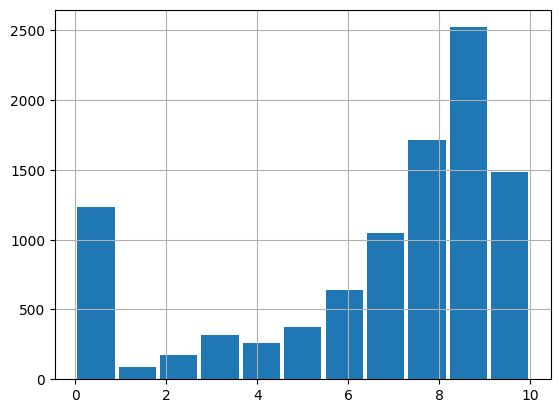

series_id    5331163
step         5331163
fold         5331163
raw_oof      5331163
target          9846
sub_step        9846
raw_step        9846
event           9846
dtype: int64

In [4]:
thresholds = [12, 36, 60, 90, 120, 150, 180, 240, 300, 360]
dfs = []
for (series_id, event), label_df in labels.groupby(["series_id", "event"]):
    sub_df = sub[(sub["series_id"] == series_id) & (sub["event"] == event)].reset_index(drop=True)
    targets = np.zeros(len(sub_df))
    for thresh in thresholds:
        matched = np.zeros(len(sub_df), dtype=bool)
        for step in label_df["step"].values:
            min_dist = thresh
            min_idx = -1            
            for idx, sub_step in enumerate(sub_df["step"].values):
                if matched[idx]:
                    continue
                dist = abs(step - sub_step)
                if dist < min_dist:
                    min_dist = dist
                    min_idx = idx
            if min_idx != -1:
                targets[min_idx] += 1
                matched[min_idx] = True
    sub_df["target"] = targets
    sub_df["sub_step"] = sub_df["step"].values
    dfs.append(sub_df)
sub = pd.concat(dfs).reset_index(drop=True)
plt.hist(sub["target"].values, bins=11, rwidth=0.9)
plt.grid()
plt.show()

oof = oof[["series_id", "step", "fold", "raw_oof"]].merge(
    sub[["target", "series_id", "sub_step", "raw_step", "event"]], 
    left_on=["series_id", "step"], 
    right_on=["series_id", "raw_step"], 
    how="left",
    )
(~oof.isna()).sum()

In [5]:
oof.head()

,series_id,step,fold,raw_oof,target,sub_step,raw_step,event
0,038441c925bb,11.5,2,0.999819,NaN,NaN,NaN,NaN
1,038441c925bb,35.5,2,0.999644,NaN,NaN,NaN,NaN
2,038441c925bb,59.5,2,0.993865,NaN,NaN,NaN,NaN
3,038441c925bb,83.5,2,0.995005,NaN,NaN,NaN,NaN
4,038441c925bb,107.5,2,0.994551,NaN,NaN,NaN,NaN


## 特徴生成

In [6]:
def generate_features(train: pd.DataFrame):
    features = Features()

    # 時刻
    train["total_seconds"] = train.index % (24 * 60 * 60 // CFG["feature"]["agg_freq"])
    features.add_num_feature("total_seconds")    

    columns = ["raw_oof"]

    # その人のその時刻での平均的な測定値
    gb = train.groupby("total_seconds")[columns].mean()
    gb.columns = [f"{c}_mean" for c in columns]
    train["raw_oof_mean"] = train["total_seconds"].map(gb["raw_oof_mean"])
    features.add_num_features(gb.columns.tolist())

    # diff
    f_names = [f"{c}_diff_abs" for c in columns]
    train[f_names] = train[columns].diff().abs()
    features.add_num_features(f_names)

    columns += f_names
    columns += gb.columns.tolist()

    # rolling
    dts = [1, 2, 3, 4, 5, 10, 20, 50, 100, 200, 500, 1000]
    shift_features_dic = {}
    for dt in dts:       
        shift_features = []

        f_names = [f"{c}_rolling_mean_{dt}" for c in columns]
        train[f_names] = train[columns].rolling(dt, center=True).mean()
        features.add_num_features(f_names)
        shift_features += f_names

        f_names = [f"{c}_rolling_std_{dt}" for c in columns]
        train[f_names] = train[columns].rolling(dt, center=True).std()
        features.add_num_features(f_names)
        shift_features += f_names

        f_names = [f"{c}_rolling_max_{dt}" for c in columns]
        train[f_names] = train[columns].rolling(dt, center=True).max()
        features.add_num_features(f_names)
        shift_features += f_names

        f_names = [f"{c}_rolling_min_{dt}" for c in columns]
        train[f_names] = train[columns].rolling(dt, center=True).min()
        features.add_num_features(f_names)
        shift_features += f_names

        f_names = [f"{c}_rolling_median_{dt}" for c in columns]
        train[f_names] = train[columns].rolling(dt, center=True).median()
        features.add_num_features(f_names)
        shift_features += f_names

        f_names = [f"{c}_rolling_square_mean_{dt}" for c in columns]
        train[f_names] = ((train[columns] ** 2).rolling(dt, center=True).mean())
        features.add_num_features(f_names)
        shift_features += f_names

        shift_features_dic[dt] = shift_features

    # shift
    used = set()
    for dt, shift_features in shift_features_dic.items():
        for c in [0.5, 1]:
            _dt = int(dt * c)
            if _dt == 0 or _dt in used:
                continue
            f_names_plus = [f"{c}_shift_{_dt}" for c in shift_features]
            train[f_names_plus] = train[shift_features].shift(_dt)
            features.add_num_features(f_names_plus)

            f_names_minus = [f"{c}_shift_{-_dt}" for c in shift_features]
            train[f_names_minus] = train[shift_features].shift(-_dt)
            features.add_num_features(f_names_minus)

            f_names_diff = [f"{c}_shift_{_dt}_diff" for c in shift_features]
            train[f_names_diff] = train[f_names_plus].values - train[f_names_minus].values
            features.add_num_features(f_names_diff)
            used.add(_dt)

    train = train.dropna(subset=["target"]).reset_index(drop=True)

    train = reduce_mem_usage(train)
    gc.collect()
    return train, features

def generate_features_for_group(group):
    _, df = group
    df, features = generate_features(df)
    return df, features

In [7]:
groups = list(oof.groupby("series_id"))

with Pool(30) as pool:
    results = list(tqdm(pool.imap(generate_features_for_group, groups), total=len(groups)))

dfs, features_list = zip(*results)
features = features_list[0]

100%|██████████| 277/277 [02:31<00:00,  1.82it/s]


In [20]:
train = pd.concat(dfs).reset_index(drop=True)
display(train.head())
print(train.shape)

,series_id,step,fold,raw_oof,target,sub_step,raw_step,event,total_seconds,raw_oof_mean,...,raw_oof_mean_rolling_max_1000_shift_1000_diff,raw_oof_rolling_min_1000_shift_1000_diff,raw_oof_diff_abs_rolling_min_1000_shift_1000_diff,raw_oof_mean_rolling_min_1000_shift_1000_diff,raw_oof_rolling_median_1000_shift_1000_diff,raw_oof_diff_abs_rolling_median_1000_shift_1000_diff,raw_oof_mean_rolling_median_1000_shift_1000_diff,raw_oof_rolling_square_mean_1000_shift_1000_diff,raw_oof_diff_abs_rolling_square_mean_1000_shift_1000_diff,raw_oof_mean_rolling_square_mean_1000_shift_1000_diff
0,038441c925bb,5027.5,2,0.102411,9.0,5015.0,5027.5,onset,209,0.105448,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,038441c925bb,10883.5,2,0.226021,7.0,10871.0,10883.5,wakeup,453,0.390346,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,038441c925bb,20435.5,2,0.210595,4.0,20423.0,20435.5,onset,851,0.841119,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,038441c925bb,27443.5,2,0.610531,7.0,27431.0,27443.5,wakeup,1143,0.366249,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,038441c925bb,40019.5,2,0.122573,10.0,40007.0,40019.5,onset,1667,0.456444,...,-0.000015,-0.008351,0.0,-0.225928,-0.726039,0.003246,-0.543192,-0.384111,0.001267,-0.294017


(9846, 983)


In [21]:
train["bin_event"] = train["event"].map({"onset": 0.0, "wakeup": 1.0})
features.add_num_feature("bin_event")

## 学習

In [22]:
# 学習
trn_oof, models = fit_xgb(train[features.all_features()], train["target"], train["fold"].astype(
    int), params=CFG["xgboost"], es_rounds=50)
train["oof"] = trn_oof

# 保存
for i, model in enumerate(models):
    model.save_model(os.path.join(CFG["output_dir"], f'xgb_fold{i}.model'))

  0%|          | 0/5 [00:00<?, ?it/s]

== fold 0 ==
[0]	eval-rmse:6.56686
[50]	eval-rmse:2.58368
[90]	eval-rmse:2.58813


 20%|██        | 1/5 [00:03<00:15,  3.82s/it]

== fold 1 ==
[0]	eval-rmse:6.51956
[50]	eval-rmse:2.43356
[100]	eval-rmse:2.43358
[143]	eval-rmse:2.43431


 40%|████      | 2/5 [00:09<00:15,  5.08s/it]

== fold 2 ==
[0]	eval-rmse:6.38543
[50]	eval-rmse:2.46110
[88]	eval-rmse:2.46370


 60%|██████    | 3/5 [00:13<00:08,  4.39s/it]

== fold 3 ==
[0]	eval-rmse:6.41393
[50]	eval-rmse:2.54711
[85]	eval-rmse:2.56131


 80%|████████  | 4/5 [00:16<00:03,  3.97s/it]

== fold 4 ==
[0]	eval-rmse:6.33674
[50]	eval-rmse:2.64893
[80]	eval-rmse:2.66300


100%|██████████| 5/5 [00:19<00:00,  3.99s/it]


In [23]:
train["score"] = train["oof"]

In [24]:
sub = train[["series_id", "sub_step", "score", "event"]]
sub["step"] = sub["sub_step"].astype(int)
sub.head()

,series_id,sub_step,score,event,step
0,038441c925bb,5015.0,8.291412,onset,5015
1,038441c925bb,10871.0,6.833763,wakeup,10871
2,038441c925bb,20423.0,4.049777,onset,20423
3,038441c925bb,27431.0,8.138564,wakeup,27431
4,038441c925bb,40007.0,8.714565,onset,40007


score: 0.6253


event   tolerance
onset   12           0.037502
        36           0.278739
        60           0.499362
        90           0.615352
        120          0.702037
        150          0.742542
        180          0.771863
        240          0.804480
        300          0.823570
        360          0.831056
wakeup  12           0.078708
        36           0.346782
        60           0.525039
        90           0.648519
        120          0.713020
        150          0.755429
        180          0.786872
        240          0.828142
        300          0.852154
        360          0.864442
dtype: float64

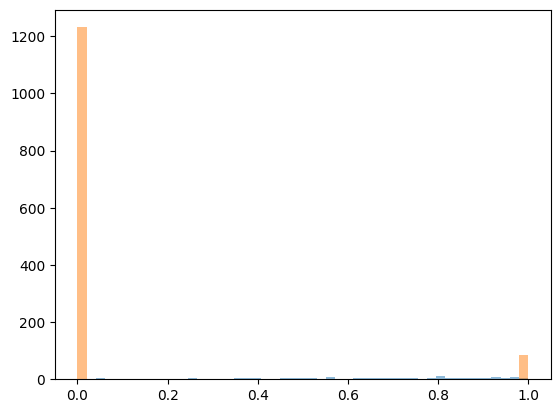

In [25]:
labels = pd.read_csv(f"{CFG['dataset']['competition_dir']}/train_events.csv").dropna()
score, ap_table = compute_comptetition_metric(labels, sub)
print(f"score: {score:.4f}")
display(ap_table)
plt.hist(train["oof"], bins=np.linspace(0, 1, 50), alpha=0.5)
plt.hist(train["target"], bins=np.linspace(0, 1, 50), alpha=0.5)
plt.show()